# Scaling collpase cleaned

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fssa import quality
from tqdm import tqdm
import numpy.ma as ma
import numpy as np
import seaborn as sns
from scipy.optimize import minimize

In [35]:
def load_IDs(L, seeds):
    Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

    ID = -1*np.ones((len(seeds),len(Ws)))
    R2 = -1*np.ones((len(seeds),len(Ws)))
    
    count = 0
    missing = []
    for seed in seeds:
        try:
            data = np.atleast_2d(np.load("data/2nn_L_{0}/2nn_L_{0}_seed_{1}.npy".format(L,seed), allow_pickle=True))[0]
            ID[seed] = np.array([data[i]['ID'] for i in range(len(Ws))])
            R2[seed] = np.array([data[i]['rsquared'] for i in range(len(Ws))])
            
        except:
            missing.append(seed)
            continue
            
    ID = ma.masked_equal(ID, -1)
    print("Loaded {0} out of {1} seeds".format(len(seeds)-len(missing), len(seeds)))
    return ID, R2

def x_func(rho, rho_c, l, nu):
    return np.power(l, 1./nu) * (rho-rho_c)

def x_BKT(rho, rho_c, l, alpha):
    return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))

def y_func(y, l, zeta,nu):
    return np.power(l, -zeta/nu) * y

def goal_function(args = [3.,2.2,1.2, 1.4], bounds=[(3.1,3.9),(1.,3.),(1.,3.),(0.,3.)]):
    ''' rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]'''
    rho_c, nu, zeta, alpha = args[0],  args[1],  args[2], args[3]
    
    x,y,dy = scaledata(l,rho,a,da,rho_c,nu,zeta, alpha)
    
    '''
    i = rho_c
    
    if i < bounds[0][0]:
        return quality(x,y,dy) * (1+ abs(bounds[0][0]-i))*2
        
    elif i > bounds[0][1]:
        return quality(x,y,dy) * (1+abs(i-bounds[0][1]))*2
    else:
    '''
    return quality(x,y,dy)
                
                
    
    
def scaledata(l, rho, a, da, rho_c, nu, zeta, alpha):
    # rho_c, nu, and zeta should be float
    rho_c = float(rho_c)
    nu = float(nu)
    zeta = float(zeta)   

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    '''x = np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c) ## old'''
    x = x_BKT(rho_mesh, rho_c,l_mesh,alpha)
    y = np.power(l_mesh, - zeta / nu) * a
    dy = np.power(l_mesh, - zeta / nu) * da

    sorting_index = np.argsort(x)[0]
    
    x = x[:,sorting_index]
    y = y[:,sorting_index]
    dy = dy[:, sorting_index]

    return x, y, dy

def autoscale(l, rho, a, da, rho_c0, nu0, zeta0, alpha0, bounds=None, **kwargs):
    

    ret = minimize(
        goal_function,
        [rho_c0, nu0, zeta0,alpha0],
        method='nelder-mead',
        options={
            'xatol': 1e-4,
            'fatol': 1e-4,
            'bounds':bounds,
        
        },
        
        
    )
    
    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )
    varco

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
    
    
    return ret

def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm
    This is a helper function and not supposed to be called directly.
    Parameters
    ----------
    sim : ndarray
        the final simplex
    fsim : ndarray
        the function values at the vertices of the final simplex
    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco


In [17]:
Ws = np.concatenate([np.arange(1,2.6,0.2), np.arange(2.6,4.55,0.05), np.arange(4.7,6.2,0.2)])

ID8, R2_8 = load_IDs(8, range(0,1000))
ID10, R2_10 = load_IDs(10, range(0,1000))
ID12, R2_12 = load_IDs(12, range(0,500))
ID14, R2_14 = load_IDs(14, range(0,100))

Loaded 1000 out of 1000 seeds
Loaded 1000 out of 1000 seeds
Loaded 500 out of 500 seeds
Loaded 100 out of 100 seeds


In [22]:
l = [8,10,12,14]
rho = Ws
a = np.vstack([ma.average(ID, axis=0, weights=R2) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

da = np.vstack([np.array([np.sqrt(np.cov(ID14[:,W], 
                aweights=R2_14[:,W])) for W in range(len(Ws))]) for ID, R2 in zip([ID8,ID10,ID12,ID14],
                                                                   [R2_8,R2_10,R2_12,R2_14])])

start,stop = 8,47
a_full, da_full, rho_full = a.copy(), da.copy(), rho.copy()
a, da, rho = a[:,start:stop],da[:,start:stop],rho[start:stop]
rho

array([2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 ,
       3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65,
       3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 ,
       4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ])

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-21-aa87221ae868>:27: RuntimeWarning: divide by zero encountered in true_divide
  return l*np.exp(-alpha/np.sqrt(abs(rho-rho_c)))
100%|██████████| 100/100 [00:02<00:00, 47.82it/s]


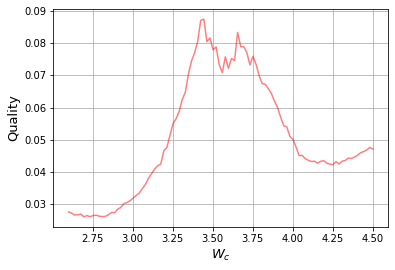

In [23]:
out = []
rs = np.linspace(min(rho),max(rho),100)
for r in tqdm(rs):
    out.append(goal_function([r,1.65,2.17,1.53], bounds=[(3.45,3.75),(1.,3.),(1.,3.),(0.,3.)]))
plt.plot(rs,out, c='r', alpha=.5)
plt.xlabel('$W_c$', fontsize=13)
plt.ylabel('Quality', fontsize=13)
plt.grid()
plt.show()


In [34]:
ret = autoscale(l, rho, a, da, 3.55,1.6,1.9, 1.4, bounds=[(3.4,3.75),(1.,3.),(1.,3.),(0.,3.)])
#ret['errors'] = np.sqrt(np.diag(abs(ret['varco'])))
#ret['rho'], ret['nu'], ret['zeta'], ret['alpha'] = ret['x']
#ret['drho'], ret['dnu'], ret['dzeta'], ret['dalpha'] = ret['errors']
ret

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method nelder-mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
<ipython-input-33-fb1818f5d9d7>:77: OptimizeWarning: Unknown solver options: bounds
  ret = minimize(


         alpha: 1.278666115390326
        dalpha: 0.43099976180321214
           dnu: 0.2115709267854769
          drho: 0.0262448142927577
         dzeta: 0.17339644320374814
        errors: array([0.02624481, 0.21157093, 0.17339644, 0.43099976])
 final_simplex: (array([[4.33032045, 1.60233232, 1.71120082, 1.27866612],
       [4.33032082, 1.60239656, 1.71115966, 1.27865714],
       [4.3303208 , 1.60224559, 1.71126042, 1.2786629 ],
       [4.33032106, 1.6023894 , 1.71116886, 1.27864278],
       [4.33032122, 1.60239174, 1.71116801, 1.27863992]]), array([0.02611757, 0.02611757, 0.02611759, 0.02611762, 0.02611762]))
           fun: 0.02611756726967191
       message: 'Optimization terminated successfully.'
          nfev: 279
           nit: 145
            nu: 1.6023323162944716
           rho: 4.330320446715389
        status: 0
       success: True
         varco: array([[ 0.00068879,  0.00140873,  0.00253983, -0.01311648],
       [ 0.00140873,  0.04476226, -0.02903077, -0.00866554],
 

In [76]:
x, y, dy = scaledata(l, rho, a, da, ret['rho'], ret['nu'], ret['zeta'], ret['alpha'])

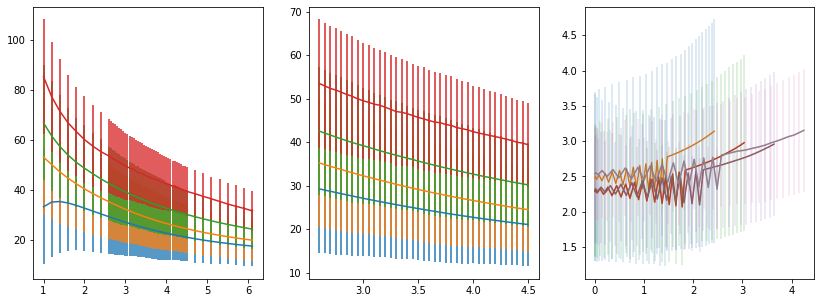

In [63]:
fig, ax = plt.subplots(1,3, figsize=(14,5))

for i,j,k in zip(np.vstack([rho_full,rho_full,rho_full,rho_full]),a_full,da_full):
    ax[0].errorbar(i,j, yerr=k)    

for i,j,k in zip(np.vstack([rho,rho,rho,rho]),a,da):
    ax[1].errorbar(i,j, yerr=k)    

for i,j,k in zip(x,y,dy):
    ax[2].errorbar(i,j, yerr=k, lw=.3)
    ax[2].plot(i,j)
#ax[1].set_xlim(0,100)